#DATA LOADING AND PREPROCESSING

Import the necessary packages

In [ ]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from google.colab import drive
import numpy as np
import seaborn as sns
import plotly.offline as po
import plotly.graph_objs as go
drive.mount('/content/drive')
from sklearn.metrics import f1_score

Mounted at /content/drive


Load the data and check the features and their data types

In [ ]:
#Load data
#First upload the train.csv file in this colab
training_data = pd.read_csv('/content/drive/MyDrive/Assignments advanced analytics/Assignment 1/data/train.csv')

print("Original data: ")
print(training_data.columns)

print("Data types:")
print(training_data.dtypes)

Original data: 
Index(['Gender', 'Age', 'Connect_Date', 'L_O_S', 'Dropped_Calls', 'tariff',
       'Handset', 'Peak_calls_Sum', 'Peak_mins_Sum', 'OffPeak_calls_Sum',
       'OffPeak_mins_Sum', 'Weekend_calls_Sum', 'Weekend_mins_Sum',
       'International_mins_Sum', 'Nat_call_cost_Sum', 'AvePeak', 'AveOffPeak',
       'AveWeekend', 'National_calls', 'National mins', 'AveNational',
       'All_calls_mins', 'Dropped_calls_ratio', 'Usage_Band', 'Mins_charge',
       'call_cost_per_min', 'actual call cost', 'Total_call_cost',
       'Total_Cost', 'Tariff_OK', 'average cost min', 'Peak ratio',
       'OffPeak ratio', 'Weekend ratio', 'Nat-InterNat Ratio',
       'high Dropped calls', 'No Usage', 'target', 'id'],
      dtype='object')
Data types:
Gender                     object
Age                       float64
Connect_Date               object
L_O_S                     float64
Dropped_Calls             float64
tariff                     object
Handset                    object
Peak_calls_

5044

Check the nr of missing rows

In [ ]:
missing_v_rows = len(training_data[training_data.isnull().any(axis=1)])
print("Nr of missing values: ", missing_v_rows)

Nr of missing values:  4


In [ ]:
training_data['Connect_Date'] = pd.to_datetime(training_data['Connect_Date'], format='%d/%m/%y')
corr = training_data[['Connect_Date','L_O_S']].corr()
print(corr)

              Connect_Date  L_O_S
Connect_Date           1.0   -1.0
L_O_S                 -1.0    1.0


Preprocess the data:
* Drop missing values
* Convert 'F' and 'T' to 0 and 1 respectively
* Use one-hot encoding for categorical features
* Drop the "connect date" column as it is completely correlated with L_O_S
* Standardize the numerical features

In [ ]:
def preprocess_data(data):
    # Make a copy of the data
    data_pp = data.copy()

    data_pp = data_pp.dropna()

    # Change 'F' and 'T' into 0 and 1
    data_pp['high Dropped calls'] = data_pp['high Dropped calls'].replace({'F': 0, 'T': 1})
    data_pp['No Usage'] = data_pp['No Usage'].replace({'F': 0, 'T': 1})

    # One-hot-encoding for categorical columns
    data_pp = pd.get_dummies(data_pp, columns=['Gender', 'tariff', 'Handset', 'Usage_Band', 'Tariff_OK'])

    # Drop the date column
    data_pp.drop(columns=['Connect_Date'], inplace=True)

    #Standardize the numerical columns
    numerical = ['Age','Peak_calls_Sum','Weekend_mins_Sum','AvePeak','AveOffPeak','AveWeekend','National_calls',
                 'National mins','AveNational','All_calls_mins', 'Mins_charge', 'call_cost_per_min',
                 'actual call cost', 'Total_call_cost', 'Total_Cost', 'Nat-InterNat Ratio','OffPeak_mins_Sum',
                 'OffPeak_calls_Sum','International_mins_Sum', 'Weekend_calls_Sum','Weekend_mins_Sum','Peak_mins_Sum','L_O_S']

    scaler = StandardScaler()

    data_pp[numerical] = scaler.fit_transform(data_pp[numerical])

    return data_pp

pp_training_data = preprocess_data(training_data)

print("Preprocessed data: ")
print(pp_training_data)

Preprocessed data: 
           Age     L_O_S  Dropped_Calls  Peak_calls_Sum  Peak_mins_Sum  \
0     1.457971 -0.315004            2.0       -0.740157      -1.104134   
1    -0.500038  0.919517            1.0       -0.389578       0.019112   
2     1.144690  0.316501            1.0       -0.331148      -0.767041   
3     2.162855 -0.443205            1.0       -0.648339      -0.777761   
4    -0.500038 -0.868165            1.0       -0.940488      -0.793246   
...        ...       ...            ...             ...            ...   
5039 -1.204922  0.271393            2.0       -0.368710       0.913660   
5040 -0.186757  1.107069            1.0       -0.435487      -0.602664   
5041 -0.656679 -1.226651            0.0        1.363317       3.320957   
5042  1.144690 -0.125078            2.0       -0.698421      -1.185132   
5043  2.319495 -0.732842            0.0       -0.381231      -0.607428   

      OffPeak_calls_Sum  OffPeak_mins_Sum  Weekend_calls_Sum  \
0              0.826100    

#TRAINING

In [ ]:
#Creation training data and test data
X_train, X_val, y_train, y_val = train_test_split(pp_training_data.drop(columns=['target','id']),
                                                    pp_training_data['target'],
                                                    test_size=0.2,
                                                    random_state=43)


In [ ]:
def profit_top20(X_data, probabilities):
    data = pd.DataFrame(X_data, columns=X_data.columns)
    data['predicted_prob'] = probabilities

    data_sorted = data.sort_values(by='predicted_prob', ascending=False)

    top_20_customers = data_sorted.head(20)

    profit_top20 = top_20_customers['average cost min'].sum()

    return profit_top20

In [ ]:
#Defining optimal C value
C = [1, .5, .25, .1, .05, .025, .01, .005, .0025]
l1_metrics = np.zeros((len(C),8))
l1_metrics[:,0] = C
for index in range(0,len(C)):
  logreg = LogisticRegression(penalty='l1',C = C[index], solver = 'liblinear')
  logreg.fit(X_train,y_train)
  pred_val_y = logreg.predict(X_val)
  prob_val_y = logreg.predict_proba(X_val)[:, 1]
  l1_metrics[index,1] = np.count_nonzero(logreg.coef_)
  l1_metrics[index,2] = accuracy_score(y_val,pred_val_y)
  l1_metrics[index,3] = precision_score(y_val,pred_val_y)
  l1_metrics[index,4] = recall_score(y_val,pred_val_y)
  l1_metrics[index,5] = f1_score(y_val, pred_val_y)
  l1_metrics[index,6] = roc_auc_score(y_val, prob_val_y)
  l1_metrics[index,7] = profit_top20(X_val,prob_val_y)

col_names = ['C','Non-zero coeffs','Accuracy','Precision','Recall','f1_score','AUC','Profit@top20']
pd.DataFrame(l1_metrics,columns = col_names)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



,C,Non-zero coeffs,Accuracy,Precision,Recall,f1_score,AUC,Profit@top20
0,1.0000,40.0,0.934524,0.781690,0.760274,0.770833,0.940676,4.071888
1,0.5000,38.0,0.933532,0.788321,0.739726,0.763251,0.939047,4.277598
2,0.2500,33.0,0.926587,0.781250,0.684932,0.729927,0.938007,4.220435
3,0.1000,23.0,0.918651,0.780702,0.609589,0.684615,0.933152,4.440389
4,0.0500,20.0,0.916667,0.781818,0.589041,0.671875,0.926008,3.791983
5,0.0250,16.0,0.892857,0.787879,0.356164,0.490566,0.895457,3.451048
6,0.0100,5.0,0.856151,1.000000,0.006849,0.013605,0.775192,3.506493
7,0.0050,3.0,0.855159,0.000000,0.000000,0.000000,0.574691,3.688755
8,0.0025,2.0,0.855159,0.000000,0.000000,0.000000,0.553837,3.402540


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       862
           1       0.78      0.61      0.68       146

    accuracy                           0.92      1008
   macro avg       0.86      0.79      0.82      1008
weighted avg       0.91      0.92      0.91      1008



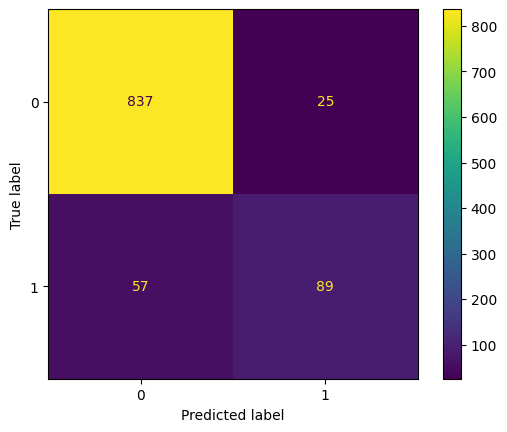

AUC:  0.9331754759558847
Profit@top20:  4.440389


In [ ]:
#Creating logistic regression model
log_reg = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 0.1)

log_reg.fit(X_train,y_train)

predictions = log_reg.predict(X_val)

print(classification_report(y_val,predictions))

# Plot confusion matrix with labels
cnf_matrix = confusion_matrix(y_val,predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=log_reg.classes_)
cm_display.plot()
plt.show()

#Calculating AUC using predicted probabilities
probabilities = log_reg.predict_proba(X_val)[:, 1]
print("AUC: ", roc_auc_score(y_val,probabilities))


#Now calculating the profit@top20 metric
profittop20 = profit_top20(X_val,probabilities)
print("Profit@top20: ", profittop20)

#OTHER MODEL TESTS

In [ ]:
#Fit the K-nearest Neighbor Model
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
knnmodel = KNeighborsClassifier(n_neighbors = 5, metric= 'minkowski', p=2)
knnmodel.fit(X_train,y_train)

#Predict
knn_pred = knnmodel.predict(X_test)

#Accuracy
knn_accuracy = round(accuracy_score(y_test, knn_pred) * 100, 2)

print(knn_accuracy)

# Plot confusion matrix with labels
knn_matrix = confusion_matrix(y_test,knn_pred)
plt.show()

#Calculating AUC using predicted probabilities
knn_probabilities = knnmodel.predict_proba(X_test)[:, 1]
print("AUC: ", roc_auc_score(y_test,knn_probabilities))

#Now calculating the profit@top20 metric
test_data = pd.DataFrame(X_test,columns=X_test.columns)
test_data['target'] = y_test


test_data['predicted_prob'] = knn_probabilities
test_data_sorted = test_data.sort_values(by='predicted_prob',ascending = False)
top_20_customers = test_data_sorted.head(20)
profit_top20 = top_20_customers['average cost min'].sum()
print("Profit @ top-20: ", profit_top20)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, knn_pred)
print('F1 score:', f1)


85.62
AUC:  0.6208779236886874
Profit @ top-20:  3.8743520000000005
F1 score: 0.16184971098265896


In [ ]:
#Fit the Decision Tree Classification Model
from sklearn.tree import DecisionTreeClassifier
dtmodel = DecisionTreeClassifier(criterion = "gini", random_state = 50)
dtmodel.fit(X_train, y_train)

#Predict
dt_pred = dtmodel.predict(X_test)

#Accuracy
dt_accuracy = round(accuracy_score(y_test, dt_pred) * 100, 2)

print(dt_accuracy)

# Plot confusion matrix with labels
knn_matrix = confusion_matrix(y_test,dt_pred)
plt.show()

#Calculating AUC using predicted probabilities
dt_probabilities = dtmodel.predict_proba(X_test)[:, 1]
print("AUC: ", roc_auc_score(y_test,dt_probabilities))

#Now calculating the profit@top20 metric
test_data = pd.DataFrame(X_test,columns=X_test.columns)
test_data['target'] = y_test


test_data['predicted_prob'] = dt_probabilities
test_data_sorted = test_data.sort_values(by='predicted_prob',ascending = False)
top_20_customers = test_data_sorted.head(20)
profit_top20 = top_20_customers['average cost min'].sum()
print("Profit @ top-20: ", profit_top20)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, knn_pred)
print('F1 score:', f1)

90.58
AUC:  0.8070637827147251
Profit @ top-20:  3.16185
F1 score: 0.16184971098265896


In [ ]:
#Fit Random Forest Classification Model
from sklearn.ensemble import RandomForestClassifier
rfmodel = RandomForestClassifier(n_estimators = 100, random_state = 0)
rfmodel.fit(X_train, y_train)

#predict
rf_pred = rfmodel.predict(X_test)

#Accuracy
rf_accuracy = round(accuracy_score(y_test, rf_pred) * 100, 2)

print("Accuracy:", rf_accuracy)

# Plot confusion matrix with labels
knn_matrix = confusion_matrix(y_test,rf_pred)
plt.show()

#Calculating AUC using predicted probabilities
rf_probabilities = rfmodel.predict_proba(X_test)[:, 1]
print("AUC: ", roc_auc_score(y_test,rf_probabilities))


#Now calculating the profit@top20 metric
test_data = pd.DataFrame(X_test,columns=X_test.columns)
test_data['target'] = y_test


test_data['predicted_prob'] = rf_probabilities
test_data_sorted = test_data.sort_values(by='predicted_prob',ascending = False)
top_20_customers = test_data_sorted.head(20)
profit_top20 = top_20_customers['average cost min'].sum()
print("Profit @ top-20: ", profit_top20)
print(test_data_sorted[["predicted_prob",'average cost min']].head(20))
print(test_data_sorted["predicted_prob"].head(20))
from sklearn.metrics import f1_score
f1 = f1_score(y_test, rf_pred)
print('F1 score:', f1)

Accuracy: 92.26
AUC:  0.9115665356541269
Profit @ top-20:  3.4139790000000003
      predicted_prob  average cost min
1482            0.93          0.164009
3054            0.92          0.174743
491             0.90          0.175558
4888            0.86          0.189476
787             0.85          0.199253
949             0.85          0.181024
1128            0.85          0.191099
2742            0.84          0.185551
2907            0.83          0.168338
2078            0.83          0.139551
65              0.82          0.179611
4391            0.82          0.139795
3663            0.82          0.186837
3311            0.81          0.150822
2570            0.81          0.161900
3840            0.81          0.167942
4283            0.80          0.192686
2819            0.80          0.150042
1437            0.80          0.148111
2246            0.80          0.167631
1482    0.93
3054    0.92
491     0.90
4888    0.86
787     0.85
949     0.85
1128    0.85
2742    0.84

#TEST EVALUATION

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Assignments advanced analytics/Assignment 1/data/test.csv')

numerical_cols = test_data.select_dtypes(include='number').columns
test_data[numerical_cols] = test_data[numerical_cols].fillna(test_data[numerical_cols].median())

categorical_cols = test_data.select_dtypes(include='object').columns
test_data[categorical_cols] = test_data[categorical_cols].fillna(test_data[categorical_cols].mode().iloc[0])

pp_test_data = preprocess_data(test_data)

test_prob = log_reg.predict_proba(pp_test_data.drop(columns = ['id']))

pos_prob = test_prob[:,1]

result_df = pd.DataFrame({'ID': pp_test_data['id'], 'PRED': pos_prob})
print(result_df)
result_df.to_csv('/content/drive/MyDrive/Assignment 1/results/results.csv', index = False)

profitTop20 = profit_top20(pp_test_data.drop(columns=['id']),pos_prob)
print("Profit @ top-20: ", profitTop20)

           ID      PRED
0     K751808  0.024297
1     K837351  0.053333
2     K548114  0.049207
3     K736156  0.032874
4     K508080  0.022012
...       ...       ...
1677  K588314  0.056750
1678  K826807  0.080519
1679  K982731  0.080740
1680  K623037  0.062279
1681  K883413  0.023762

[1682 rows x 2 columns]
Profit @ top-20:  4.635776


RESULTS0: accuracy = 92%; AUC = 92%; profit20 = 3,3
*   missing numerical values imputed with means
*   missing categorical values imputed with mode
*   F and T transformed to 0 and 1
*   One hot encoding for categorical columns
*   Removed the connect data column
*   SMOTE
--> Leaderboard results: 2.833718; 0.892142

RESULTS1: accuracy = 92%; AUC = 92%; profit20 = 4,5
*   missing numerical values imputed with means
*   missing categorical values imputed with mode
*   F and T transformed to 0 and 1
*   One hot encoding for categorical columns
*   Removed the connect data column
*   Add l1 regularization to log reg model
*   SMOTE
--> Leaderboard results: 2.493699; 0.892181

RESULTS2: accuracy = 93%; AUC = 92%; profit20 = 2,4
*   missing numerical values imputed with means
*   missing categorical values imputed with mode
*   F and T transformed to 0 and 1
*   One hot encoding for categorical columns
*   Removed the connect data column
*   Add l1 regularization to log reg model
*   Normalize numerical columns
*   SMOTE
--> Leaderboard results: 1.6; 0.90

RESULTS3: accuracy = 93%; AUC = 92%; profit20 = 2,1
*   missing numerical values imputed with means
*   missing categorical values imputed with mode
*   F and T transformed to 0 and 1
*   One hot encoding for categorical columns
*   Removed the connect data column
*   Add l2 regularization to log reg model
*   Normalize numerical columns
*   SMOTE
--> Leaderboard results: 1.4; 0.91

RESULTS4: accuracy = 93%; AUC = 92%; profit20 = 6,9
*   missing numerical values imputed with means
*   missing categorical values imputed with mode
*   F and T transformed to 0 and 1
*   One hot encoding for categorical columns
*   Removed the connect data column
*   Add l2 regularization to log reg model
*   Standardize numerical columns
*   SMOTE
--> Leaderboard results: 2; 0.9

RESULTS5: accuracy = 93%; AUC = 90%; profit20 = 12.6
*   rows with missing values removed in training set
*   missing numerical values imputed with means in test set
*   missing categorical values imputed with mode in test set
*   F and T transformed to 0 and 1
*   One hot encoding for categorical columns
*   Removed the connect data column
*   Standardize numerical columns
*   SMOTE
--> Leaderboard results: 2.55; 0.91

RESULTS7: accuracy = 93%; AUC = 91%; profit20 = 14,8
*   rows with missing values removed in training set
*   missing numerical values imputed with means in test set
*   missing categorical values imputed with mode in test set
*   F and T transformed to 0 and 1
*   One hot encoding for categorical columns
*   Removed the connect data column
*   Standardize numerical columns
*   l1 regularization with C = 0.25
--> Leaderboard results: 3.06; 0.91

RESULTS8: accuracy = 93%; AUC = 90%; profit20 = 15,3
*   rows with missing values removed in training set
*   missing numerical values imputed with means in test set
*   missing categorical values imputed with mode in test set
*   F and T transformed to 0 and 1
*   One hot encoding for categorical columns
*   Removed the connect data column
*   Standardize numerical columns
*   l1 regularization with C = 0.1
--> Leaderboard results:

RESULT9: AUC:  0.9122579131294678 Profit @ top-20:  11.872545874674028
*  Added class imbalance formula
*  L1 regulariation with C= 1

RESULT 10: AUC:  0.9085789469273509 Profit @ top-20:  4.51 Accuracy: 93.06
* Used LogReg model
* Removed average min cost out of normalization
* Changed l1 penalization C = 0.25
--> Leaderboard results metric one: 3.06; 0.91

RESULT 11: AUC:  Accuracy: 92.26 AUC:  0.91 Profit @ top-20:  3.41
* Used RandomForest
--> Leaderboard results metric one: 2.43; 0.92

Result 12: AUC:  0.89 Profit @ top-20:  4.083964 Accuracy: 92.56
* Logregs with l1 C=0.5
* SMOTE to tackle class imbalance

Result 13:  AUC:  0.903316097781726 Profit @ top-20:  4.1855 Accuracy: 86.41
* Logregs with misclassification costs
* No L1 penalization
--> Results: 2.592285, 0.896444

In [ ]:
--